In [334]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf

In [335]:
# Apply KNN to forecast my time series (available), using GridSearchCV to find the best parameters
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import pickle
import glob

In [336]:
def plot_descomposition(df, target):
    
    # Time series decomposition
    decomposition = seasonal_decompose(df[target], model='additive', period=30)
    
    # Plot
    fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=('Original', 'Trend', 'Seasonality', 'Residuos'))
    fig.add_trace(go.Scatter(x=df.index, y=df[target], mode='lines', name='Original'), row=1, col=1)
    fig.add_trace(go.Scatter(x=decomposition.trend.index, y=decomposition.trend, mode='lines', name='Trend'), row=2, col=1)
    fig.add_trace(go.Scatter(x=decomposition.seasonal.index, y=decomposition.seasonal, mode='lines', name='Seasonality'), row=3, col=1)
    fig.add_trace(go.Scatter(x=decomposition.resid.index, y=decomposition.resid, mode='lines', name='Residuos'), row=4, col=1)
    fig.update_layout(title_text='Descomposición de la serie de tiempo', showlegend=True)
    
    return fig

In [337]:
def create_features(df, date_col):
    
    # Convert the 'date' column to datetime
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Extract date-based features
    df['hour'] = df[date_col].dt.hour
    df['dayofweek'] = df[date_col].dt.dayofweek
    df['month'] = df[date_col].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df[date_col].dt.day
    df['weekofyear'] = df[date_col].dt.isocalendar().week
    df['weekofyear'] = df['weekofyear'].astype(int)
    
    # Set the 'date' column as the index
    df = df.set_index('date')
    
    return df

In [338]:
def add_lags(df, target, hours):
    """
    Add lagged values as new columns to a DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - target (str): The column name for the target variable.
    - hours (int): The number of lagged hours to add.

    Returns:
    - pd.DataFrame: The DataFrame with added lagged columns.
    """
    
    # Create a dictionary mapping timestamps to target values
    target_map = df[target].to_dict()
    
    # Iterate through lag hours and add lagged columns
    for i in range(1, hours + 1):
        df[f'lag{i}'] = df.index.to_series() - pd.DateOffset(hours=i*8)
        df[f'lag{i}'] = df[f'lag{i}'].map(target_map)
    
    return df

In [339]:
# Read data
lavb_8h = pd.read_parquet("lavb_8h.parquet")
lavb_8h.sort_values(by='date', ascending=True, inplace=True)
lavb_8h.head(5)

,origin,destination,date,available
0,Los Angeles (CA),Stockton (CA),2023-05-15 00:00:00,160.0
1,Los Angeles (CA),Stockton (CA),2023-05-15 08:00:00,147.0
2,Los Angeles (CA),Stockton (CA),2023-05-15 16:00:00,17.0
3,Los Angeles (CA),Stockton (CA),2023-05-16 00:00:00,22.0
4,Los Angeles (CA),Stockton (CA),2023-05-16 08:00:00,47.0


In [340]:
lavb_8h.shape

(429, 4)

In [341]:
lavb_8h.isna().sum()

origin         0
destination    0
date           0
available      0
dtype: int64

In [342]:
lavb_8h.dtypes

origin                 object
destination            object
date           datetime64[ns]
available             float64
dtype: object

In [343]:
px.line(lavb_8h, x="date", y="available", markers = True)

In [344]:
plot_descomposition(lavb_8h, "available")

In [345]:
df_features = create_features(lavb_8h.copy(), "date")
df_features

,origin,destination,available,hour,dayofweek,month,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,
2023-05-15 00:00:00,Los Angeles (CA),Stockton (CA),160.0,0,0,5,135,15,20
2023-05-15 08:00:00,Los Angeles (CA),Stockton (CA),147.0,8,0,5,135,15,20
2023-05-15 16:00:00,Los Angeles (CA),Stockton (CA),17.0,16,0,5,135,15,20
2023-05-16 00:00:00,Los Angeles (CA),Stockton (CA),22.0,0,1,5,136,16,20
2023-05-16 08:00:00,Los Angeles (CA),Stockton (CA),47.0,8,1,5,136,16,20
...,...,...,...,...,...,...,...,...,...
2023-10-03 08:00:00,Los Angeles (CA),Stockton (CA),127.0,8,1,10,276,3,40
2023-10-03 16:00:00,Los Angeles (CA),Stockton (CA),96.0,16,1,10,276,3,40
2023-10-04 00:00:00,Los Angeles (CA),Stockton (CA),91.0,0,2,10,277,4,40


In [346]:
px.box(df_features, x="hour", y="available")

In [347]:
px.box(df_features, x="dayofweek", y="available")

In [348]:
px.box(df_features, x="month", y="available")

In [349]:
px.box(df_features, x="dayofmonth", y="available")

In [350]:
px.box(df_features, x="weekofyear", y="available")

In [351]:
px.box(df_features, x="hour", y="available", color="dayofweek", animation_frame='month')

In [352]:
px.histogram(df_features, x="available", animation_frame='month')

In [353]:
px.histogram(df_features, x="available", animation_frame='dayofweek')

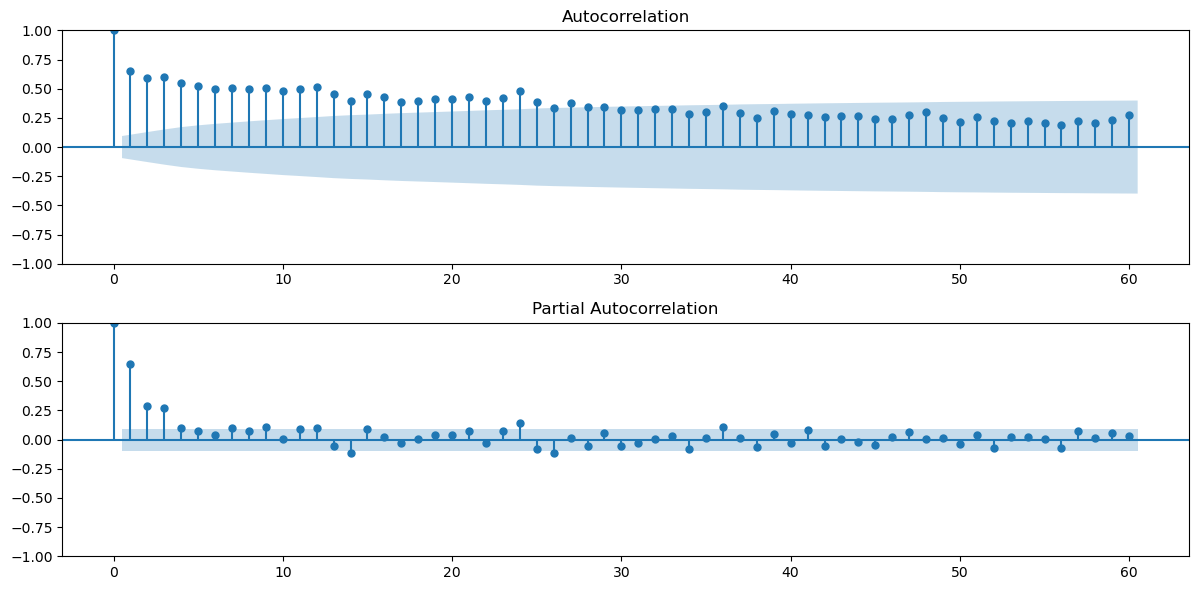

In [354]:
# Gráficos de autocorrelación y autocorrelación parcial
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plot_acf(lavb_8h['available'], ax=plt.gca(), lags=60)

plt.subplot(2, 1, 2)
plot_pacf(lavb_8h['available'], ax=plt.gca(), lags=60)

plt.tight_layout()
plt.show()

In [355]:
df_features = add_lags(df_features, "available", 3)
df_features

,origin,destination,available,hour,dayofweek,month,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
date,,,,,,,,,,,,
2023-05-15 00:00:00,Los Angeles (CA),Stockton (CA),160.0,0,0,5,135,15,20,NaN,NaN,NaN
2023-05-15 08:00:00,Los Angeles (CA),Stockton (CA),147.0,8,0,5,135,15,20,160.0,NaN,NaN
2023-05-15 16:00:00,Los Angeles (CA),Stockton (CA),17.0,16,0,5,135,15,20,147.0,160.0,NaN
2023-05-16 00:00:00,Los Angeles (CA),Stockton (CA),22.0,0,1,5,136,16,20,17.0,147.0,160.0
2023-05-16 08:00:00,Los Angeles (CA),Stockton (CA),47.0,8,1,5,136,16,20,22.0,17.0,147.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-03 08:00:00,Los Angeles (CA),Stockton (CA),127.0,8,1,10,276,3,40,118.0,128.0,229.0
2023-10-03 16:00:00,Los Angeles (CA),Stockton (CA),96.0,16,1,10,276,3,40,127.0,118.0,128.0
2023-10-04 00:00:00,Los Angeles (CA),Stockton (CA),91.0,0,2,10,277,4,40,96.0,127.0,118.0


In [356]:
df_features = df_features.dropna()
df_features

,origin,destination,available,hour,dayofweek,month,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
date,,,,,,,,,,,,
2023-05-16 00:00:00,Los Angeles (CA),Stockton (CA),22.0,0,1,5,136,16,20,17.0,147.0,160.0
2023-05-16 08:00:00,Los Angeles (CA),Stockton (CA),47.0,8,1,5,136,16,20,22.0,17.0,147.0
2023-05-16 16:00:00,Los Angeles (CA),Stockton (CA),32.0,16,1,5,136,16,20,47.0,22.0,17.0
2023-05-17 00:00:00,Los Angeles (CA),Stockton (CA),221.0,0,2,5,137,17,20,32.0,47.0,22.0
2023-05-17 08:00:00,Los Angeles (CA),Stockton (CA),65.0,8,2,5,137,17,20,221.0,32.0,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-03 08:00:00,Los Angeles (CA),Stockton (CA),127.0,8,1,10,276,3,40,118.0,128.0,229.0
2023-10-03 16:00:00,Los Angeles (CA),Stockton (CA),96.0,16,1,10,276,3,40,127.0,118.0,128.0
2023-10-04 00:00:00,Los Angeles (CA),Stockton (CA),91.0,0,2,10,277,4,40,96.0,127.0,118.0


In [357]:
X = df_features.drop(columns=['available', 'origin', 'destination'])
y = df_features['available']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# KNN Model

In [358]:
# Apply KNN to forecast my time series (available) tunning hyperparamets without cross validation
grid_knn = None
if (len(glob.glob("knn_model.pkl")) != 0):
    
     grid_knn = pickle.load(open('knn_model.pkl','rb'))
     
else:
    
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)

    knn = KNeighborsRegressor()
    param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'weights': ['uniform', 'distance'],
                    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'leaf_size': [10, 20, 30, 40, 50],
                    'p': [1, 2]}

    grid_knn = GridSearchCV(knn, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_knn.fit(X_train, y_train)
    # Export model to pickle
    pickle.dump(grid_knn, open('knn_model.pkl', 'wb'))
    
print("Best parameters: ", grid_knn.best_params_)
print("Best score: ", grid_knn.best_score_)


Best parameters:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Best score:  -2959.133691634562


In [359]:
# Predictions
# scaler = StandardScaler()
# X_test_scaled = scaler.fit_transform(X_test)
y_pred = grid_knn.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
models_metrics = [{'Model': 'KNN', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape}]
print(models_metrics)

# Plot predictions vs real values
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test.index, y=y_test, mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=X_test.index, y=y_pred, mode='lines', name='Predicción'))
fig.update_layout(title_text='Predicción vs Real (KNN)', showlegend=True)
fig.show()


[{'Model': 'KNN', 'MSE': 1138.6159034564303, 'RMSE': 33.74338310626885, 'MAPE': 0.3879847345638002}]


# Ridge

In [360]:
# Apply Ridge to forecast my time series (available) tunning hyperparamets without cross validation

if (len(glob.glob("ridge_model.pkl")) != 0):
    
    grid_rdg = pickle.load(open('ridge_model.pkl','rb'))
        
else:

    ridge = Ridge()
    param_grid = {'alpha': [0.1, 0.5, 1, 5, 10, 50, 100],
                    'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

    grid_rdg = GridSearchCV(ridge, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_rdg.fit(X_train, y_train)
    # Export model to pickle
    pickle.dump(grid_rdg, open('ridge_model.pkl', 'wb'))
    
print("Best parameters: ", grid_rdg.best_params_)
print("Best score: ", grid_rdg.best_score_)

Best parameters:  {'alpha': 100, 'solver': 'saga'}
Best score:  -6012.7430754686075


In [361]:
# Calculate metrics
y_pred = grid_rdg.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
models_metrics.append({'Model': 'Ridge', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape})
print(models_metrics)

# Plot predictions vs real values
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test.index, y=y_test, mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=X_test.index, y=y_pred, mode='lines', name='Predicción'))
fig.update_layout(title_text='Predicción vs Real (Ridge)', showlegend=True)
fig.show()

[{'Model': 'KNN', 'MSE': 1138.6159034564303, 'RMSE': 33.74338310626885, 'MAPE': 0.3879847345638002}, {'Model': 'Ridge', 'MSE': 1493.5037117109828, 'RMSE': 38.645875739993045, 'MAPE': 0.36040840789723366}]


# Lasso

In [362]:
# Apply Lasso to forecast my time series (available) tunning hyperparamets without cross validation

if (len(glob.glob("lasso_model.pkl")) != 0):
        
    grid_lss = pickle.load(open('lasso_model.pkl','rb'))
        
else:
        
    lasso = Lasso()
    param_grid = {'alpha': [0.1, 0.5, 1, 5, 10, 50, 100],
                        'selection': ['cyclic', 'random']}
    
    grid_lss = GridSearchCV(lasso, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_lss.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_lss, open('lasso_model.pkl', 'wb'))
        
print("Best parameters: ", grid_lss.best_params_)
print("Best score: ", grid_lss.best_score_)

Best parameters:  {'alpha': 100, 'selection': 'cyclic'}
Best score:  -2491.8441365531985


In [363]:
# Calculate metrics
y_pred = grid_lss.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
models_metrics.append({'Model': 'Lasso', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape})
print(models_metrics)

# Plot predictions vs real values
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test.index, y=y_test, mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=X_test.index, y=y_pred, mode='lines', name='Predicción'))
fig.update_layout(title_text='Predicción vs Real (Lasso)', showlegend=True)
fig.show()

[{'Model': 'KNN', 'MSE': 1138.6159034564303, 'RMSE': 33.74338310626885, 'MAPE': 0.3879847345638002}, {'Model': 'Ridge', 'MSE': 1493.5037117109828, 'RMSE': 38.645875739993045, 'MAPE': 0.36040840789723366}, {'Model': 'Lasso', 'MSE': 1304.2833957592813, 'RMSE': 36.11486391721948, 'MAPE': 0.361052221785555}]


# Naive Bayes

In [364]:
# Apply Naive Bayes to forecast my time series (available) tunning hyperparamets without cross validation
if (len(glob.glob("naive_model.pkl")) != 0):
    
    grid_nb = pickle.load(open('naive_model.pkl','rb'))
    
else:
    
    nb = GaussianNB()
    param_grid = {'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]}
    
    grid_nb = GridSearchCV(nb, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_nb.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_nb, open('naive_model.pkl', 'wb'))
    
print("Best parameters: ", grid_nb.best_params_)
print("Best score: ", grid_nb.best_score_)

Best parameters:  {'var_smoothing': 1e-07}
Best score:  -5238.628571428571


In [365]:
# Calculate metrics
y_pred = grid_nb.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
models_metrics.append({'Model': 'Naive Bayes', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape})
print(models_metrics)

# Plot predictions vs real values
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test.index, y=y_test, mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=X_test.index, y=y_pred, mode='lines', name='Predicción'))
fig.update_layout(title_text='Predicción vs Real (Naive Bayes)', showlegend=True)
fig.show()

[{'Model': 'KNN', 'MSE': 1138.6159034564303, 'RMSE': 33.74338310626885, 'MAPE': 0.3879847345638002}, {'Model': 'Ridge', 'MSE': 1493.5037117109828, 'RMSE': 38.645875739993045, 'MAPE': 0.36040840789723366}, {'Model': 'Lasso', 'MSE': 1304.2833957592813, 'RMSE': 36.11486391721948, 'MAPE': 0.361052221785555}, {'Model': 'Naive Bayes', 'MSE': 2078.3372093023254, 'RMSE': 45.58878381030059, 'MAPE': 0.5237457674428726}]


# XGBoost

In [366]:
# Apply XGBoost to forecast my time series (available) tunning hyperparamets without cross validation
from xgboost import XGBRegressor

if (len(glob.glob("xgb_model.pkl")) != 0):
    
    grid_xgb = pickle.load(open('xgb_model.pkl','rb'))
    
else:
    
    xgb = XGBRegressor()
    param_grid = {'n_estimators': [100, 500, 1000],
                    'max_depth': [3, 5, 10],
                    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]}
    
    grid_xgb = GridSearchCV(xgb, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_xgb.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_xgb, open('xgb_model.pkl', 'wb'))

print("Best parameters: ", grid_xgb.best_params_)
print("Best score: ", grid_xgb.best_score_)

Best parameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Best score:  -4122.142541242742


In [367]:
# Calculate metrics
y_pred = grid_xgb.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
models_metrics.append({'Model': 'XGBoost', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape})
print(models_metrics)

# Plot predictions vs real values
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test.index, y=y_test, mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=X_test.index, y=y_pred, mode='lines', name='Predicción'))
fig.update_layout(title_text='Predicción vs Real (XGBoost)', showlegend=True)
fig.show()

[{'Model': 'KNN', 'MSE': 1138.6159034564303, 'RMSE': 33.74338310626885, 'MAPE': 0.3879847345638002}, {'Model': 'Ridge', 'MSE': 1493.5037117109828, 'RMSE': 38.645875739993045, 'MAPE': 0.36040840789723366}, {'Model': 'Lasso', 'MSE': 1304.2833957592813, 'RMSE': 36.11486391721948, 'MAPE': 0.361052221785555}, {'Model': 'Naive Bayes', 'MSE': 2078.3372093023254, 'RMSE': 45.58878381030059, 'MAPE': 0.5237457674428726}, {'Model': 'XGBoost', 'MSE': 1093.2945473781335, 'RMSE': 33.06500487491471, 'MAPE': 0.37851027414768423}]


# SVM

In [368]:
# Apply SVM to forecast my time series (available) tunning hyperparamets without cross validation
if (len(glob.glob("svm_model.pkl")) != 0):
    
    grid_svm = pickle.load(open('svm_model.pkl','rb'))
    
else:

    pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('svm', SVR())])
    
    param_grid = {'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                    'svm__degree': [1, 2, 3, 4, 5],
                    'svm__gamma': ['scale', 'auto']}
    
    grid_svm = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_svm.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_svm, open('svm_model.pkl', 'wb'))
    
print("Best parameters: ", grid_svm.best_params_)
print("Best score: ", grid_svm.best_score_)

Best parameters:  {'svm__degree': 1, 'svm__gamma': 'scale', 'svm__kernel': 'poly'}
Best score:  -4881.473470141121


In [369]:
# Calculate metrics
y_pred = grid_svm.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
models_metrics.append({'Model': 'SVM', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape})
print(models_metrics)

# Plot predictions vs real values
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test.index, y=y_test, mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=X_test.index, y=y_pred, mode='lines', name='Predicción'))
fig.update_layout(title_text='Predicción vs Real (SVM)', showlegend=True)
fig.show()

[{'Model': 'KNN', 'MSE': 1138.6159034564303, 'RMSE': 33.74338310626885, 'MAPE': 0.3879847345638002}, {'Model': 'Ridge', 'MSE': 1493.5037117109828, 'RMSE': 38.645875739993045, 'MAPE': 0.36040840789723366}, {'Model': 'Lasso', 'MSE': 1304.2833957592813, 'RMSE': 36.11486391721948, 'MAPE': 0.361052221785555}, {'Model': 'Naive Bayes', 'MSE': 2078.3372093023254, 'RMSE': 45.58878381030059, 'MAPE': 0.5237457674428726}, {'Model': 'XGBoost', 'MSE': 1093.2945473781335, 'RMSE': 33.06500487491471, 'MAPE': 0.37851027414768423}, {'Model': 'SVM', 'MSE': 1274.7424271847794, 'RMSE': 35.7035352197059, 'MAPE': 0.3933462937358793}]


# MLP

In [374]:
# Apply MLP to forecast my time series (available) tunning hyperparamets without cross validation, do the required steps
# to apply the model

if (len(glob.glob("mlp_model.pkl")) != 0):
    
    grid_mlp = pickle.load(open('mlp_model.pkl','rb'))
    
else:

    pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('mlp', MLPRegressor())])

    param_grid = {'mlp__hidden_layer_sizes': [(10,), (50,), (100,)],
                    'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'],
                    'mlp__solver': ['lbfgs', 'sgd', 'adam'],
                    'mlp__learning_rate': ['constant', 'invscaling', 'adaptive']}
    
    grid_mlp = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_mlp.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_mlp, open('mlp_model.pkl', 'wb'))
    
print("Best parameters: ", grid_mlp.best_params_)
print("Best score: ", grid_mlp.best_score_)

Best parameters:  {'mlp__activation': 'logistic', 'mlp__hidden_layer_sizes': (50,), 'mlp__learning_rate': 'adaptive', 'mlp__solver': 'sgd'}
Best score:  -2802.8648689351758


c:\Users\coold\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



In [371]:
# Calculate metrics
y_pred = grid_mlp.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
models_metrics.append({'Model': 'MLP', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape})
print(models_metrics)

# Plot predictions vs real values
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test.index, y=y_test, mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=X_test.index, y=y_pred, mode='lines', name='Predicción'))
fig.update_layout(title_text='Predicción vs Real (MLP)', showlegend=True)
fig.show()

[{'Model': 'KNN', 'MSE': 1138.6159034564303, 'RMSE': 33.74338310626885, 'MAPE': 0.3879847345638002}, {'Model': 'Ridge', 'MSE': 1493.5037117109828, 'RMSE': 38.645875739993045, 'MAPE': 0.36040840789723366}, {'Model': 'Lasso', 'MSE': 1304.2833957592813, 'RMSE': 36.11486391721948, 'MAPE': 0.361052221785555}, {'Model': 'Naive Bayes', 'MSE': 2078.3372093023254, 'RMSE': 45.58878381030059, 'MAPE': 0.5237457674428726}, {'Model': 'XGBoost', 'MSE': 1093.2945473781335, 'RMSE': 33.06500487491471, 'MAPE': 0.37851027414768423}, {'Model': 'SVM', 'MSE': 1274.7424271847794, 'RMSE': 35.7035352197059, 'MAPE': 0.3933462937358793}, {'Model': 'MLP', 'MSE': 1184.0593591533843, 'RMSE': 34.410163602537324, 'MAPE': 0.38613454762043653}]


In [372]:
pd.DataFrame(models_metrics)

,Model,MSE,RMSE,MAPE
0,KNN,1138.615903,33.743383,0.387985
1,Ridge,1493.503712,38.645876,0.360408
2,Lasso,1304.283396,36.114864,0.361052
3,Naive Bayes,2078.337209,45.588784,0.523746
4,XGBoost,1093.294547,33.065005,0.378510
5,SVM,1274.742427,35.703535,0.393346
6,MLP,1184.059359,34.410164,0.386135


# Forecasting using Data Augmentation and AutoML

In [375]:
def augmentation_ts(time_series):

    augmented_series = pd.Series()

    # Calculate the number of elements in the original time series
    num_elements = len(time_series)

    # Iterate through the original time series
    for i in range(num_elements):
        
        # Append the current value from the original series
        augmented_series = augmented_series.append(pd.Series(time_series.iloc[i]))
        
        # Calculate the intermediate value by averaging the current and next day's values
        if i < num_elements - 1:
            intermediate_value = (time_series.iloc[i] + time_series.iloc[i + 1]) / 2
            augmented_series = augmented_series.append(pd.Series(intermediate_value))
            
    return augmented_series

In [376]:
lavb_8h['available']

0      160.0
1      147.0
2       17.0
3       22.0
4       47.0
       ...  
424    127.0
425     96.0
426     91.0
427    103.0
428     78.0
Name: available, Length: 429, dtype: float64

In [377]:
aug_ts = augmentation_ts(lavb_8h['available'])

C:\Users\coold\AppData\Local\Temp\ipykernel_41056\1251106261.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\coold\AppData\Local\Temp\ipykernel_41056\1251106261.py:11: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\coold\AppData\Local\Temp\ipykernel_41056\1251106261.py:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\coold\AppData\Local\Temp\ipykernel_41056\1251106261.py:11: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\coold\AppData\Local\Temp\ipykernel_41056\1251106261.py:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in 